In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_CUPR_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 104 × 16589
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
COPs,0,2
MFOLs,4,6
MOL_A,5,8
MOL_B,5,8
MOL_C,5,9
MOL_D,5,4
MOL_E,3,7
MOL_F,3,6
MOL_G,4,7


In [5]:
adata_pb.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate
donor_stim_1_0-0-0-0-0-0-0-0-0-0-0-0,(this study),stim,cycl_OPCs,1,stim_1,Cupr_5w_1,0,36253,10.498277,1
donor_stim_2_0-0-0-0-0-0-0-0-0-0-0-0,(this study),stim,cycl_OPCs,2,stim_2,Cupr_5w_2,0,55755,10.928722,2
donor_ctrl_1_0-1-0-0-0-0-0-0-0-0-0-0,(this study),ctrl,OPCs,1,ctrl_1,Cupr_ctrl_Adams_1,0,53408,10.885716,1
donor_ctrl_2_0-1-0-0-0-0-0-0-0-0-0-0,(this study),ctrl,OPCs,2,ctrl_2,Cupr_ctrl_Adams_2,0,44455,10.702233,2
donor_ctrl_5_0-1-0-0-0-0-0-0-0-0-0-0,Shen et al. 2021,ctrl,OPCs,5,ctrl_5,Cupr_ctrl_Shen_3,0,84201,11.340962,5


In [6]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['MOL_A', 'MOL_G'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (24, 16589)


In [7]:
pub_map = {
    '(this study)': 'Adams',
    'Shen et al. 2021': 'Shen'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [8]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [9]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-1-0-0-0-0-0-0,(this study),ctrl,MOL_A,1,ctrl_1,Cupr_ctrl_Adams_1,Adams,161410,11.991703,1,MOL_A_Cupr_ctrl_Adams_1
donor_ctrl_2_0-1-0-0-0-0-0-0,(this study),ctrl,MOL_A,2,ctrl_2,Cupr_ctrl_Adams_2,Adams,93222,11.442739,2,MOL_A_Cupr_ctrl_Adams_2
donor_ctrl_3_0-1-0-0-0-0-0-0,Shen et al. 2021,ctrl,MOL_A,3,ctrl_3,Cupr_ctrl_Shen_2,Shen,200979,12.210956,3,MOL_A_Cupr_ctrl_Shen_2
donor_ctrl_4_0-1-0-0-0-0-0-0,Shen et al. 2021,ctrl,MOL_A,4,ctrl_4,Cupr_ctrl_Shen_1,Shen,141998,11.863568,4,MOL_A_Cupr_ctrl_Shen_1
donor_ctrl_5_0-1-0-0-0-0-0-0,Shen et al. 2021,ctrl,MOL_A,5,ctrl_5,Cupr_ctrl_Shen_3,Shen,623894,13.343736,5,MOL_A_Cupr_ctrl_Shen_3


# Subset for demyelination and remyelination MOL2 data

In [10]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

MOL_A_Cupr_ctrl_Adams_1
MOL_A_Cupr_ctrl_Adams_2
MOL_A_Cupr_ctrl_Shen_2
MOL_A_Cupr_ctrl_Shen_1
MOL_A_Cupr_ctrl_Shen_3
MOL_A_Cupr_5w_1
MOL_A_Cupr_5w_2
MOL_A_Cupr_4+3w_1
MOL_A_Cupr_4w_3
MOL_A_Cupr_4+3w_3
MOL_A_Cupr_4w_4
MOL_A_Cupr_4+3w_2
MOL_A_Cupr_4w_1
MOL_G_Cupr_ctrl_Adams_1
MOL_G_Cupr_ctrl_Adams_2
MOL_G_Cupr_ctrl_Shen_2
MOL_G_Cupr_ctrl_Shen_1
MOL_G_Cupr_5w_1
MOL_G_Cupr_5w_2
MOL_G_Cupr_4+3w_1
MOL_G_Cupr_4w_3
MOL_G_Cupr_4w_2
MOL_G_Cupr_4w_4
MOL_G_Cupr_4w_1


In [11]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                            'MOL_A_Cupr_ctrl_Adams_1',
                            'MOL_A_Cupr_ctrl_Adams_2',
                            'MOL_A_Cupr_ctrl_Shen_2',
                            'MOL_A_Cupr_ctrl_Shen_1',
                            'MOL_A_Cupr_ctrl_Shen_3',
                            'MOL_G_Cupr_5w_1',
                            'MOL_G_Cupr_5w_2',
                            'MOL_G_Cupr_4w_3',
                            'MOL_G_Cupr_4w_2',
                            'MOL_G_Cupr_4w_4',
                            'MOL_G_Cupr_4w_1',                              
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (11, 16589)


In [12]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [13]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
Cupr_ctrl_Adams_1,(this study),ctrl,MOL_A,1,ctrl_1,Adams,161410,11.991703,1,MOL_A_Cupr_ctrl_Adams_1
Cupr_ctrl_Adams_2,(this study),ctrl,MOL_A,2,ctrl_2,Adams,93222,11.442739,2,MOL_A_Cupr_ctrl_Adams_2
Cupr_ctrl_Shen_2,Shen et al. 2021,ctrl,MOL_A,3,ctrl_3,Shen,200979,12.210956,3,MOL_A_Cupr_ctrl_Shen_2
Cupr_ctrl_Shen_1,Shen et al. 2021,ctrl,MOL_A,4,ctrl_4,Shen,141998,11.863568,4,MOL_A_Cupr_ctrl_Shen_1
Cupr_ctrl_Shen_3,Shen et al. 2021,ctrl,MOL_A,5,ctrl_5,Shen,623894,13.343736,5,MOL_A_Cupr_ctrl_Shen_3
Cupr_5w_1,(this study),stim,MOL_G,1,stim_1,Adams,107326,11.583626,1,MOL_G_Cupr_5w_1
Cupr_5w_2,(this study),stim,MOL_G,2,stim_2,Adams,350692,12.767664,2,MOL_G_Cupr_5w_2
Cupr_4w_3,Shen et al. 2021,stim,MOL_G,4,stim_4,Shen,1535884,14.244617,4,MOL_G_Cupr_4w_3
Cupr_4w_2,Shen et al. 2021,stim,MOL_G,5,stim_5,Shen,2661468,14.794388,5,MOL_G_Cupr_4w_2
Cupr_4w_4,Shen et al. 2021,stim,MOL_G,7,stim_7,Shen,2676958,14.800192,7,MOL_G_Cupr_4w_4


# Rename the MOL clusters for NEW letter based nomenclature

In [14]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[ 0  1  0  0  4]
 [ 0  0  0  0  4]
 [ 0  7  0  1  3]
 [ 0  1  0  2  6]
 [ 0 31  0  7 12]]


# Start R code: QC of log transformation

In [15]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

                  Group Reps Batch
Cupr_ctrl_Adams_1  ctrl    1 Adams
Cupr_ctrl_Adams_2  ctrl    2 Adams
Cupr_ctrl_Shen_2   ctrl    3  Shen
Cupr_ctrl_Shen_1   ctrl    4  Shen
Cupr_ctrl_Shen_3   ctrl    5  Shen
Cupr_5w_1          stim    1 Adams
Cupr_5w_2          stim    2 Adams
Cupr_4w_3          stim    4  Shen
Cupr_4w_2          stim    5  Shen
Cupr_4w_4          stim    7  Shen
Cupr_4w_1          stim    9  Shen


In [16]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 16589    11

ctrl stim 
   5    6 


In [17]:
%%R

# Check if Socs3 is in the rownames of the count matrix
gene_name <- "Socs3"
if(gene_name %in% rownames(x$counts)) {
  # Extract expression values for Socs3
  socs3_expr <- x$counts[gene_name, ]
  
  # Print the counts for Socs3 across replicates
  print("Expression of Socs3 across the samples:")
  print(socs3_expr)
} else {
  print("Gene Socs3 not found in the dataset.")
}

[1] "Expression of Socs3 across the samples:"
Cupr_ctrl_Adams_1 Cupr_ctrl_Adams_2  Cupr_ctrl_Shen_2  Cupr_ctrl_Shen_1 
                0                 0                 0                 1 
 Cupr_ctrl_Shen_3         Cupr_5w_1         Cupr_5w_2         Cupr_4w_3 
                5                 1                 1                 3 
        Cupr_4w_2         Cupr_4w_4         Cupr_4w_1 
              472               216               379 


In [17]:
%%R

cd <- x$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [18]:
%%R

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [19]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 5144   11


In [20]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 6060   11


In [21]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 0.8287009 0.3065700


In [22]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.2299916 1.3463048 0.8385614 0.9367945 0.8475465 1.2568244 0.9856364
 [8] 0.7904981 0.9946507 0.9362894 0.9945782


In [23]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

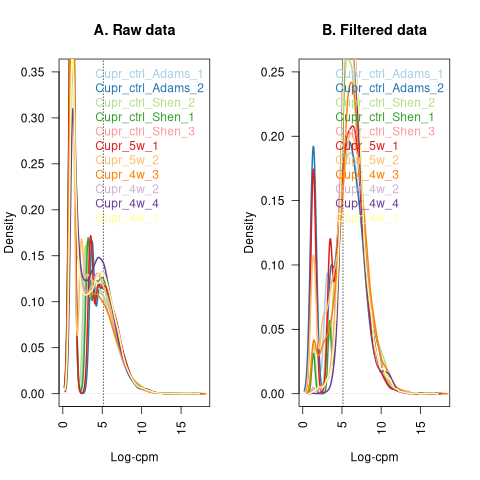

In [24]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

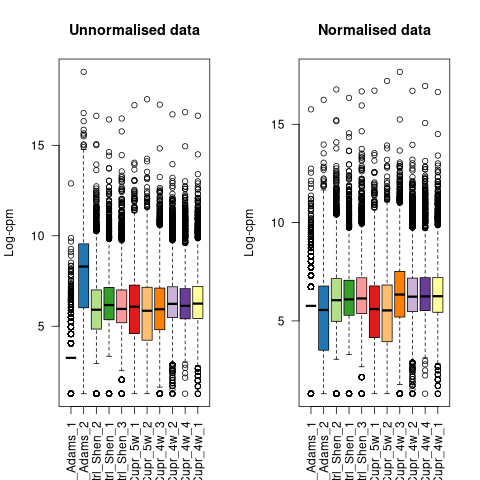

In [25]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [26]:
%%R
cd <- x2$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [27]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

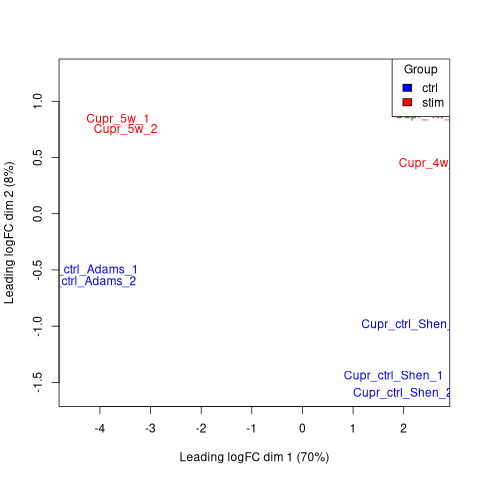

In [28]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

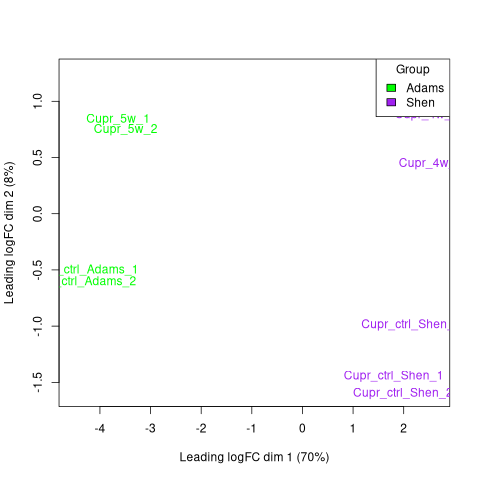

In [29]:
%%R
# Generate a numeric vector from group factors (if not already factor, convert it)
pub_factor <- as.factor(batch)
pub_colors <- as.numeric(pub_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("green", "purple")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[pub_colors])

# Adding a legend for clarity
legend("topright", legend=levels(pub_factor), fill=colors, title="Group")

In [30]:
%%R

x3$samples

                  group lib.size norm.factors
Cupr_ctrl_Adams_1  ctrl   140414    1.2299916
Cupr_ctrl_Adams_2  ctrl    79981    1.3463048
Cupr_ctrl_Shen_2   ctrl   190198    0.8385614
Cupr_ctrl_Shen_1   ctrl   129397    0.9367945
Cupr_ctrl_Shen_3   ctrl   586626    0.8475465
Cupr_5w_1          stim    91930    1.2568244
Cupr_5w_2          stim   306570    0.9856364
Cupr_4w_3          stim  1444906    0.7904981
Cupr_4w_2          stim  2425649    0.9946507
Cupr_4w_4          stim  2444723    0.9362894
Cupr_4w_1          stim  1275316    0.9945782


In [31]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [32]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [33]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [34]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=batch) 

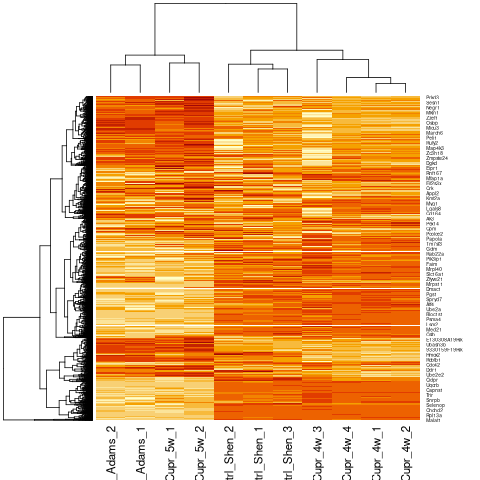

In [35]:
%%R
heatmap(logCPM)

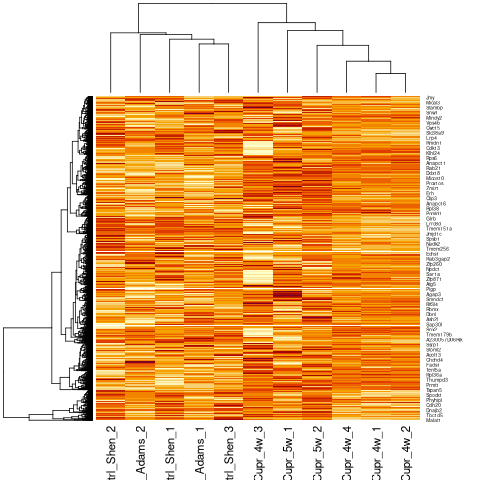

In [36]:
%%R
heatmap(logCPM_no_batch)

# Voom with quality weights

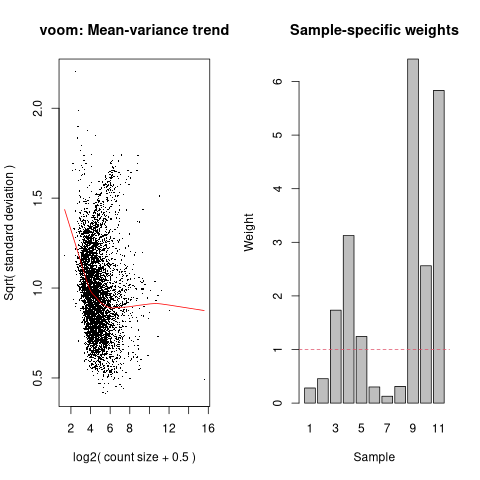

In [37]:
%%R
y <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [38]:
%%R
corfit <- duplicateCorrelation(y, design, block=batch)
corfit$consensus.correlation

[1] 0.593982


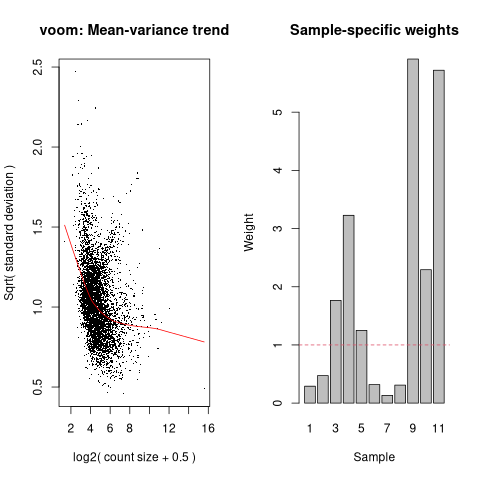

In [39]:
%%R
y2 <- voomWithQualityWeights(x2$counts, design, plot=TRUE, block=batch, correlation=corfit$consensus)

In [40]:
%%R
corfit2 <- duplicateCorrelation(y2,design,block=batch, weights=y2$targets$sample.weights)
corfit2$consensus.correlation

[1] 0.6437415


In [41]:
%%R
fit <- lmFit(y2, design, block=batch, correlation=corfit2$consensus)

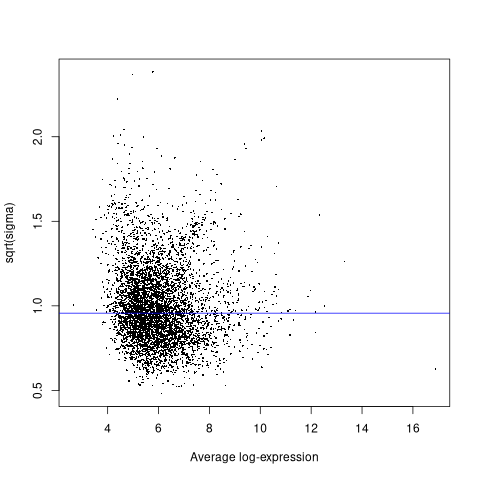

In [42]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [43]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

           logFC  AveExpr         t      P.Value    adj.P.Val        B
Ninj2  -4.607284 6.748263 -26.10690 3.340235e-13 1.718217e-09 20.37725
Jph4   -5.682385 3.820698 -23.27667 1.590012e-12 4.089510e-09 18.20506
Ptgds  -5.227826 9.807530 -22.13151 3.149304e-12 5.400007e-09 18.46735
Sgk2   -7.897536 2.657387 -21.03121 6.272674e-12 8.066659e-09 16.15682
Ccp110 -3.185825 6.733613 -19.94428 1.282088e-11 1.319012e-08 16.95061
Aspa   -2.423516 8.778888 -18.52569 3.450224e-11 2.379544e-08 16.11846
Eml2   -2.883572 6.015184 -18.47499 3.579115e-11 2.379544e-08 16.00131
Fa2h   -2.498431 8.359134 -18.42892 3.700690e-11 2.379544e-08 16.04108
Kcna1  -2.306344 8.151650 -17.58055 6.943793e-11 3.968763e-08 15.42867
Ugt8a  -2.488116 8.611744 -17.25082 8.935406e-11 4.474714e-08 15.18572


In [44]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1485


In [45]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 1016


In [46]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 462
          logFC  AveExpr        t      P.Value    adj.P.Val           B
Cdkn1a 7.760793 6.789897 7.184025 4.896421e-06 1.123674e-04  4.05369659
Syt4   6.488901 5.693444 4.404013 6.112499e-04 4.982994e-03 -0.09463786
Nupr1  5.902650 5.055217 7.219935 4.631971e-06 1.083039e-04  4.14594989
Tenm3  5.413442 4.725149 6.651018 1.138974e-05 2.197950e-04  3.38038755
Epha5  5.356033 5.257956 8.364197 8.598033e-07 2.948552e-05  5.45279277
Tenm4  5.197777 6.097571 7.323139 3.952514e-06 9.590439e-05  4.24159748


In [47]:
%%R
if ('Serpina3n' %in% rownames(genes_up_sorted)) {
    print("Serpina3n is in the index of genes_up_sorted")
} else {
    print("Serpina3n is not in the index of genes_up_sorted")
}

[1] "Serpina3n is in the index of genes_up_sorted"


In [48]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 554
                  logFC  AveExpr          t      P.Value    adj.P.Val         B
Sgk2          -7.897536 2.657387 -21.031212 6.272674e-12 8.066659e-09 16.156817
Ldlrad4       -7.730829 3.763239 -12.913518 3.986912e-09 5.397020e-07 11.086020
Rasgrp3       -7.580945 3.510930 -11.779170 1.293199e-08 1.304356e-06 10.055138
Jph4          -5.682385 3.820698 -23.276673 1.590012e-12 4.089510e-09 18.205062
5033421B08Rik -5.284706 3.998894  -7.042370 6.105389e-06 1.359572e-04  4.224753
Mgat5         -5.278473 4.021399  -6.097662 2.850247e-05 4.581772e-04  2.760473


# Save output- make sure to rename!

In [49]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/Cupr_demyel_MOL_AvG_voom_wqw_NEW.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Do results overlap with LR pairs?

In [50]:
import liana as li
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [51]:
DEG_all = pd.read_csv('./files/Cupr_demyel_MOL_AvG_voom_wqw_NEW.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(5144, 7)

In [52]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(1016, 7)

In [53]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 8


,ligand,receptor,logFC_ligand,logFC_receptor
7,Vegfa,Cd44,2.759231,2.814452
6,Hebp1,Grm7,-1.094919,-2.155399
5,Il18,Il1rapl1,-1.563539,-1.156274
0,Sema4d,Plxnb3,-1.712876,-2.063524
3,Fgf1,Cd44,-1.971690,2.814452
4,Fgf1,Fgfr2,-1.971690,-1.388958
2,Lama2,Cd44,-2.140248,2.814452
1,Lama2,Rpsa,-2.140248,1.869287


In [54]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(462, 7)

In [55]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 1


,ligand,receptor,logFC_ligand,logFC_receptor
0,Vegfa,Cd44,2.759231,2.814452


In [56]:
sigs_down = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC <= -1)]
sigs_down.shape

(554, 7)

In [57]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_down['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 4


,ligand,receptor,logFC_ligand,logFC_receptor
3,Hebp1,Grm7,-1.094919,-2.155399
2,Il18,Il1rapl1,-1.563539,-1.156274
0,Sema4d,Plxnb3,-1.712876,-2.063524
1,Fgf1,Fgfr2,-1.971690,-1.388958


In [58]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(462, 7)

In [59]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 1


,ligand,receptor,logFC_ligand,logFC_receptor
0,Vegfa,Cd44,2.759231,2.814452


In [ ]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_Cupr_demyel_MOL_AvG.csv', sep='\t', index=False)